In [1]:
import sys
import os
sys.path.append('..')


import torch

from manga_ocr.utils import get_path_project_dir
from manga_ocr.utils.ploting import plot_losses, show_images
from manga_ocr.utils.pytorch_model import get_total_parameters_count

# Load/Prepare model

In [2]:
from manga_ocr.models.recognition.crnn.crnn import CRNN

path_output_model = get_path_project_dir('data/output/models/recognition.bin')
print('path_output_model', os.path.abspath(path_output_model))

if os.path.exists(path_output_model):
    print('Loading an existing model...')
    model = torch.load(path_output_model)
else:
    print('Creating a new model...')
    model = CRNN()
    
print(model)
print(model.input_height)

path_output_model /Users/wanasit/Dropbox/Workspace_Personal/manga-ocr/data/output/models/recognition.bin
Creating a new model...
CRNN(
  (prediction): Linear(in_features=256, out_features=81, bias=True)
  (feature_extraction_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (sequential_model): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): BidirectionalRNNBlock(
      (rnn): LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
  )
)
24


In [3]:
get_total_parameters_count(model)

1143249

## Load/Prepare Dataset

In [4]:
from manga_ocr.models.recognition.recognition_dataset import RecognitionDataset

path_dataset = get_path_project_dir('data/output/generate_manga_dataset')
print('path_dataset', os.path.abspath(path_dataset))

dataset = RecognitionDataset.load_generated_dataset(path_dataset, input_height=model.input_height)
print('dataset', len(dataset))

path_dataset /Users/wanasit/Dropbox/Workspace_Personal/manga-ocr/data/output/generate_manga_dataset
dataset 5382


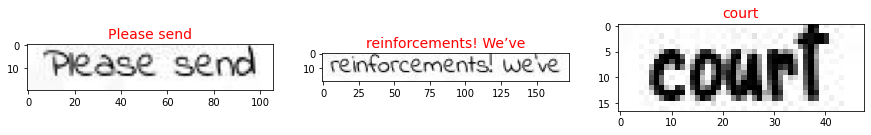

In [5]:
show_images(
    [dataset.get_line_image(0), dataset.get_line_image(1), dataset.get_line_image(-1)],
    [dataset.get_line_text(0), dataset.get_line_text(1), dataset.get_line_text(-1)],
) 

In [6]:
validation_dataset = dataset.subset(to_idx=100)
training_dataset = dataset.subset(from_idx=100)
print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

validation_dataset 100
training_dataset 5282


# Training

In [7]:
from manga_ocr.models.recognition.train import train
from IPython.display import clear_output

def show_example(model, images):
    outputs = [model.recognize(img) for img in images]
    show_images(images, outputs)


def save_and_report(i_epoch, train_losses, val_losses):
    clear_output()
    plot_losses(train_losses, val_losses)
    show_example(model, [
        dataset.get_line_image(0), dataset.get_line_image(1), dataset.get_line_image(-1)
    ])
    
    torch.save(model, path_output_model)

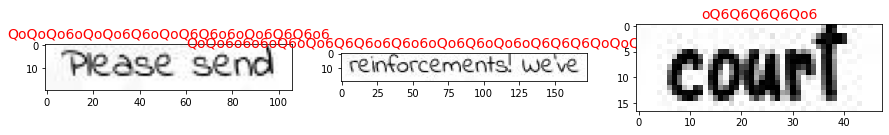

In [8]:
show_example(model, [
    dataset.get_line_image(0), dataset.get_line_image(1), dataset.get_line_image(-1)
])

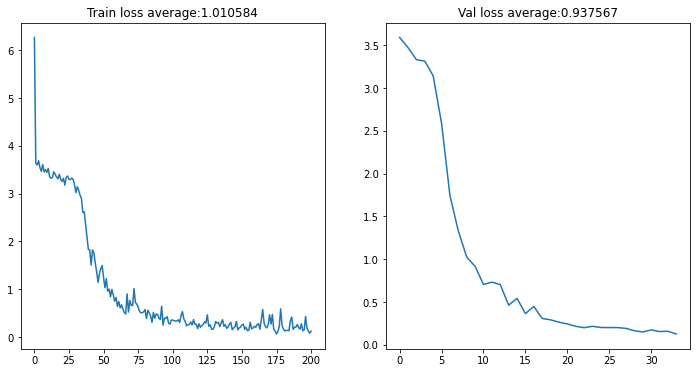

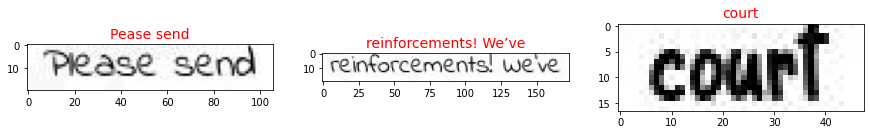

Epoch 1:  93%|█▊| 4908/5282 [14:13<01:27,  4.30it/s, training_batch_loss=0.0846]

In [ ]:
#validation_dataset = validation_dataset.subset(to_idx=10)
#training_dataset = training_dataset.subset(to_idx=50)

train(model,
      training_dataset=training_dataset,
      validation_dataset=validation_dataset,
      epoch_count=3,
      batch_size=50,
      epoch_callback=save_and_report,
      update_callback=save_and_report,
      update_every_n=300,
      validation_every_n=300
)